In [ ]:
import tensorflow as tf
import os
import numpy as np
import tensorflow.keras as keras
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from google.colab import drive
from tensorflow.python.client import device_lib
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras import Model, layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla K80


In [ ]:
try:
    drive.mount('/content/drive')
except:
    print("You are not working in Colab at the moment :(")

Mounted at /content/drive


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


In [ ]:
%%bash
DIRECTORY=TireDataset
if [ ! -d /tmp/$DIRECTORY ]; then
  mkdir -p /tmp/$DIRECTORY
  unzip -q "/content/drive/My Drive/Oktay/FlatTireDetection/FlatTireDataset.zip" -d /tmp/$DIRECTORY
fi

In [ ]:
EPOCHS = 20
T_EPOCHS = 5
CLASSES = 2
BATCH_SIZE = 8
IMG_WIDTH = 240
IMG_HEIGHT = 240
MODEL_NAME = "TRANSFER"

In [ ]:
TRAIN_PATH = '/tmp/TireDataset/train'
VAL_PATH = '/tmp/TireDataset/val'
TEST_PATH = '/tmp/TireDataset/test'

totalTrain = len(list(paths.list_images(TRAIN_PATH)))
totalVal = len(list(paths.list_images(VAL_PATH)))
totalTest = len(list(paths.list_images(TEST_PATH)))

train_datagen = ImageDataGenerator(rescale=1 / 255.0,
                                   rotation_range=270,
                                   width_shift_range=[-5, 5],
                                   height_shift_range=[-5, 5],
                                   #shear_range=0.2,
                                   #zoom_range=0.2,
                                   brightness_range=[1.0, 3.0],
                                   horizontal_flip=True,
                                   vertical_flip=True)

trainGen = train_datagen.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE)

val_datagen = ImageDataGenerator(rescale=1 / 255.0)
valGen = val_datagen.flow_from_directory(
    VAL_PATH,
    class_mode="categorical",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

testAug = ImageDataGenerator(rescale=1 / 255.0)
testGen = testAug.flow_from_directory(
    TEST_PATH,
    class_mode="categorical",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

print(trainGen.samples)
print(totalTrain)

Found 480 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
480
480


findfont: Font family ['Comic Sans MS'] not found. Falling back to DejaVu Sans.


"\nfor i in range(9):\n\t# define subplot\n\tplt.subplot(330 + 1 + i)\n\t# generate batch of images\n\tbatch = testGen.next()\n\t# convert to unsigned integers for viewing\n\timage = batch[0].astype('uint8')\n\t# plot raw pixel data\n\tplt.imshow(image)\n# show the figure\nplt.show()\n"

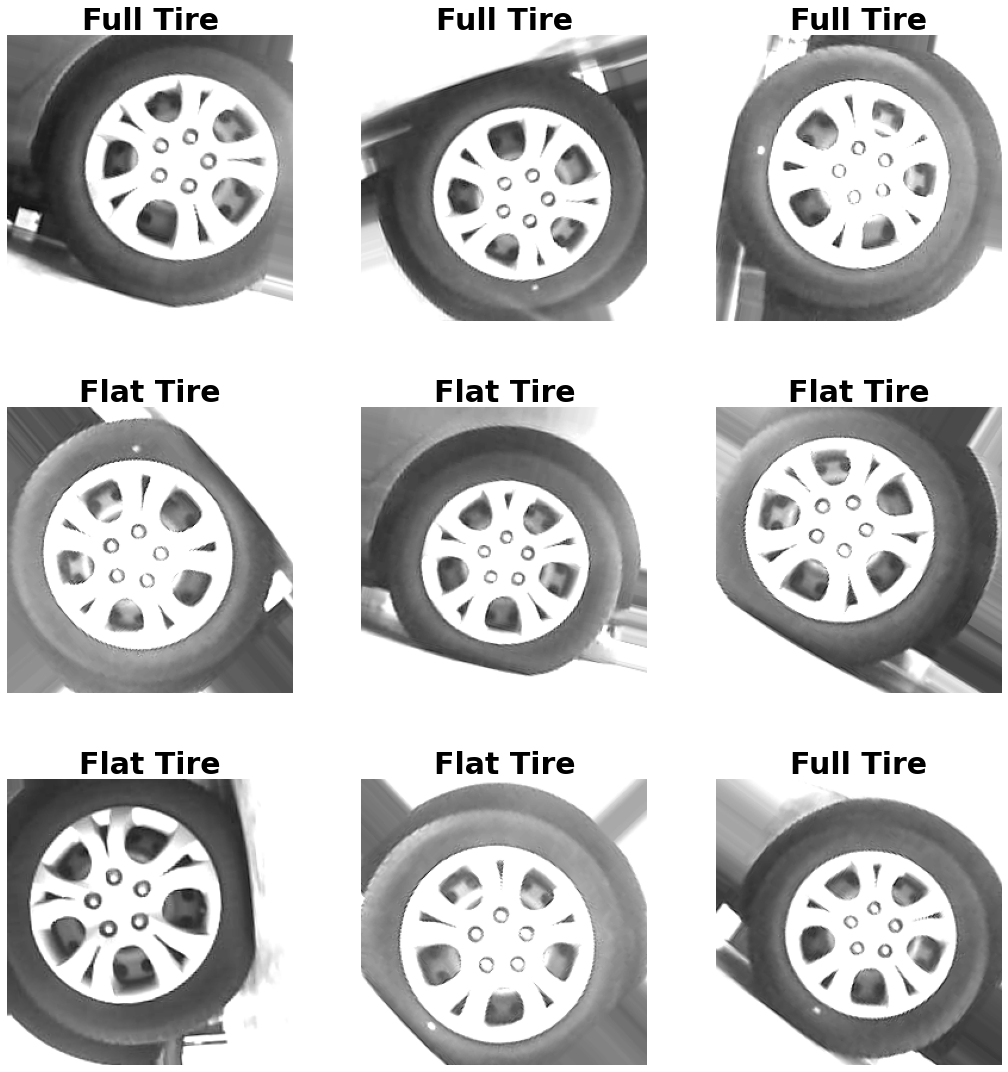

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=9, figsize=(15,15))

for i in range(9):
		plt.subplot(330 + 1 + i)
		img, label = trainGen.next()
		ax[i].imshow(img[0])
		ax[i].axis('off')
		plt.axis('off')
		title = "Flat Tire" if np.argmax(label) == 0 else "Full Tire"
		plt.title(title, fontsize=30, fontweight='bold', fontname="Comic Sans MS")
		plt.imshow(img[0])

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

plt.savefig('sample_augmented_images.png')


"""
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = testGen.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()
"""

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                              restore_best_weights=False
                                              )


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.3,
                                   patience=5,
                                   verbose=1,
                                   min_delta= 6 * 1e-3,
                                   min_lr = 6 * 1e-7,
                                   )

In [ ]:
if MODEL_NAME == "TRANSFER":
    # bismillahirrahmanirrahim
    # 3 kere nas-felak
    resnet = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3),pooling='avg')

    output = resnet.layers[-1].output
    output = tf.keras.layers.Flatten()(output)
    resnet = Model(resnet.input, output)
    res_name = []
    for layer in resnet.layers:
        res_name.append(layer.name)

    set_trainable = False
    for layer in resnet.layers:
        if layer.name in res_name[-447:]:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model = Sequential()
    model.add(resnet)
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(CLASSES, activation='sigmoid'))
    model.summary()

    model.compile(loss = tf.keras.losses.binary_crossentropy,
              optimizer = adam,
              metrics = ['accuracy', 'mse'])

    history = model.fit(
        trainGen,
        validation_data=valGen,
        callbacks=[early_stop, reduce_lr],
        epochs=T_EPOCHS)

else:
    model = Sequential([
      layers.Conv2D(16, 2, padding='same', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 2, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 2, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(64),
      layers.Dense(CLASSES, activation='sigmoid')
    ])
    model.summary()

    model.compile(loss = tf.keras.losses.binary_crossentropy,
              optimizer = adam,
              metrics = ['accuracy', 'mse'])

    history = model.fit(
        trainGen,
        validation_data=valGen,
        callbacks=[early_stop, reduce_lr],
        epochs=EPOCHS)


83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 2050      
                                                         

In [ ]:
testGen.reset()
predIdxs = model.predict(testGen)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testGen.classes, predIdxs, target_names=testGen.class_indices.keys()))
print(confusion_matrix(testGen.classes, predIdxs))

              precision    recall  f1-score   support

  flat.class       1.00      1.00      1.00        30
  full.class       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

[[30  0]
 [ 0 30]]


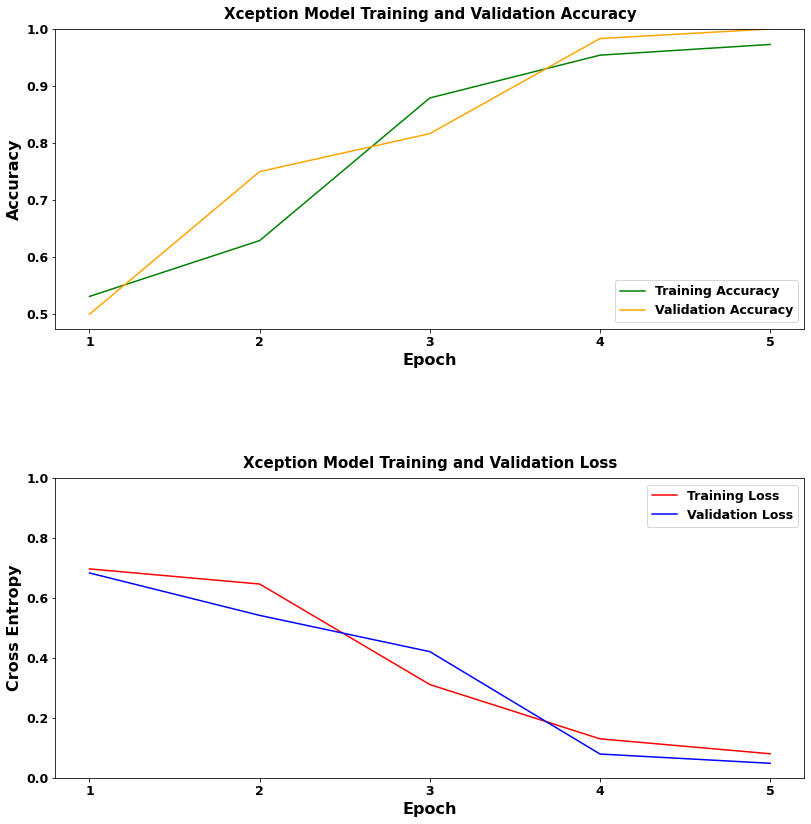

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"

font = {'size': 12.5}

plt.rc('font', **font)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, T_EPOCHS + 1)

plt.figure(figsize=(13, 13))

plt.subplot(2, 1, 1)
plt.plot(epochs, acc, label='Training Accuracy', color = 'green')
plt.plot(epochs, val_acc, label='Validation Accuracy', color = 'orange')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(loc='lower right')
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Xception Model Training and Validation Accuracy', pad=10,fontweight="bold")
plt.xlabel('Epoch', fontsize=16)
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.plot(epochs, loss, label='Training Loss', color = 'red')
plt.plot(epochs, val_loss, label='Validation Loss', color = 'blue')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy', fontsize=16)
plt.ylim([0,1.0])
plt.title('Xception Model Training and Validation Loss', pad=10, fontweight="bold")
plt.xlabel('Epoch', fontsize=16)
plt.tight_layout()

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.5)

plt.savefig('Xception-Results.png')

In [ ]:
# CLASSIFICATION REPORT AND THE CONFUSION MATRIX FOR RESNET50

testGen.reset()
predIdxs = model.predict(testGen, steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testGen.classes, predIdxs, target_names=testGen.class_indices.keys()))
print(confusion_matrix(testGen.classes, predIdxs))

              precision    recall  f1-score   support

  flat.class       1.00      1.00      1.00        30
  full.class       1.00      1.00      1.00        30

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

[[30  0]
 [ 0 30]]
